In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

## DEFINITIONS

### Diversity measures

In [3]:
def alpha_0_1(a):
    return (np.log10(a)+12)/7

In [4]:
def distance(a, s):
    a = np.asarray(a)
    s = np.asarray(s)
    diff_a = np.abs(a[:, np.newaxis] - a[np.newaxis, :])
    diff_s = np.abs(s[:, np.newaxis] - s[np.newaxis, :])
    return np.maximum(diff_a, diff_s)

In [5]:
def plasmid_sampling(B):
    B_plasmids=B[:,1:]
    nb_community_tmp=np.shape(B_plasmids)[0]
    nb_mges_tmp=np.shape(B_plasmids)[1]
    proba_tmp=B_plasmids/np.sum(B_plasmids,1).reshape((nb_community_tmp,-1))
    size_effectif_tmp=np.random.multinomial(4411,np.sum(B_plasmids,1)/np.sum(B_plasmids))
    B_sample=np.zeros((nb_community_tmp,nb_mges_tmp))
    for i in range(nb_community_tmp):
        B_sample[i]=np.random.multinomial(size_effectif_tmp[i],proba_tmp[i])
    return(B_sample)

In [6]:
def richness(B):
    # Environmental richness
    richness_env=np.zeros(3)
    tmp1=np.sum(B[:4],0)
    tmp2=np.sum(B[4:8],0)
    tmp3=np.sum(B[8:],0)
    richness_env[0]=np.sum(tmp1>0)
    richness_env[1]=np.sum(tmp2>0)
    richness_env[2]=np.sum(tmp3>0)
    # Global richness
    tmp=np.sum(B,0)
    richness_global=np.sum(tmp>0)
    
    return(richness_env,richness_global)

In [7]:
def gini_simpson(B):
    # Environmental diversities
    gini_simpson_env=np.zeros(3)
    tmp1=np.sum(B[:4],0)/np.sum(B[:4])
    tmp2=np.sum(B[4:8],0)/np.sum(B[4:8])
    tmp3=np.sum(B[8:],0)/np.sum(B[8:])
    gini_simpson_env[0]=1-np.sum(tmp1**2)
    gini_simpson_env[1]=1-np.sum(tmp2**2)
    gini_simpson_env[2]=1-np.sum(tmp3**2)
    # Global diversity
    tmp=np.sum(B,0)/np.sum(B)
    gini_simpson_global=1-np.sum(tmp**2)
    
    return(gini_simpson_env,gini_simpson_global)

In [8]:
def functional_diversity(B,a,s):
    a_transfo=alpha_0_1(a)
    s_plasmids=s[1:]
    d_matrix=distance(a_transfo,s_plasmids)
    # Environmental diversities
    diversity_env=np.zeros(3)
    tmp1=np.sum(B[:4],0)/np.sum(B[:4])
    tmp2=np.sum(B[4:8],0)/np.sum(B[4:8])
    tmp3=np.sum(B[8:],0)/np.sum(B[8:])
    diversity_env[0]=np.sum(tmp1*np.reshape(tmp1,(-1,1))*d_matrix)
    diversity_env[1]=np.sum(tmp2*np.reshape(tmp2,(-1,1))*d_matrix)
    diversity_env[2]=np.sum(tmp3*np.reshape(tmp3,(-1,1))*d_matrix)
    # Global diversity
    tmp=np.sum(B,0)/np.sum(B)
    diversity_global=np.sum(tmp*np.reshape(tmp,(-1,1))*d_matrix)
    return(diversity_env,diversity_global)

### Model

In [13]:
def R_fun(s,e=1,s_max=1,Rmin=0.9,Rmax=0.99):
    r=Rmax+(Rmin-Rmax)*(s/s_max)/(e-(e-1)*(s/s_max))
    return(r)

def e_log(a,e=1,a_min=1e-12,a_max=1e-5,e_min=0.9,e_max=0.99):
    a=a_max*(np.log10(a)-np.log10(a_min))/(np.log10(a_max)-np.log10(a_min))
    epsilon=e_max+(e_min-e_max)*(a/a_max)/(e-(e-1)*(a/a_max))
    return(epsilon)

In [14]:
def construction_stress_periodic_1(T,dt,d1,d2,i_min,i_max):
    # d1: stress duration
    # d2: no stress duration
    # i_min, i_max: min and max stress intensity
    
    stress=np.array([])
    
    while np.size(stress)<=int(T/dt):
        stress=np.concatenate((stress,np.zeros(int(d2/dt)),np.repeat(np.random.uniform(i_min,i_max),int(d1/dt))))
    
    return stress[:(int(T/dt)+1)]

In [15]:
def replication(B,dt,r):
    # dt: time step
    # r: replication rate

    G=np.random.binomial(B,r*dt)
    return G

def lyse_stress(B,dt,t,d,s):
    # dt: time step
    # d: death rate
    # s: resistance rate
    
    N=np.reshape(np.sum(B,1),(nb_community,-1))
    L=np.random.binomial(B,(N*d+f2(t,s))*dt)
    return L

def infection(B,dt,a):
    # dt: time step
    # a: plasmid horizontal transfer rate
    
    I=np.random.binomial(np.reshape(B[:,0],(nb_community,-1)),B[:,1:]*a*dt)
    return I

def transfert_vertical(B,e):
    # dt: time step
    # e: plasmid vertical transfer rate
    
    D=np.random.binomial(B,e)
    return D

def innovation(B,dt,i):
    # dt: time step
    # i: innovation rate

    N=np.random.binomial(B,i*dt)
    return N

def dispersion(B,dt,g): 
    # dt: time step
    # g: dispersal rate
    
    D=np.random.binomial(B,g*dt)    
    return D

In [17]:
def mges_incompatibles_stochastique(B0,dt,T,n,r,e,d,a,s,i,g):
    # dt: time step
    # T: final time
    # t0: initial time
    # n: number of community
    # r: vector of replication rate
    # e: vertical transfer probability
    # d: competition coefficient
    # a: vector of infection rate
    # s: vector of resistance rate
    # i: rate of mutation
    # g: diseprsion matrix
    
    nb_species_init=np.shape(B0)[1]

    richness_l=np.zeros((T,3))
    richness_g=np.zeros((T,1))
    gini_simpson_l=np.zeros((T,3))
    gini_simpson_g=np.zeros((T,1))
    diversity_l=np.zeros((T,3))
    diversity_g=np.zeros((T,1))
    
    
    for t in range(int(T/dt)):
        B0=np.int64(B0)
        B0=np.maximum(B0,0)
        B=B0
        if t%10==0:
            B_sample=plasmid_sampling(B)
            tmp=richness(B_sample)
            richness_l[int(t*dt)]=tmp[0]
            richness_g[int(t*dt)]=tmp[1]
            tmp=gini_simpson(B)
            gini_simpson_l[int(t*dt)]=tmp[0]
            gini_simpson_g[int(t*dt)]=tmp[1]
            tmp=functional_diversity(B_sample,a,s)
            diversity_l[int(t*dt)]=tmp[0]
            diversity_g[int(t*dt)]=tmp[1]

        for c1 in range(n):
            for c2 in range(c1+1,n):
                #if c2!=c1:
                G1_2=dispersion(B0[c1,:],dt,g[c1,c2])
                G2_1=dispersion(B0[c2,:],dt,g[c2,c1])
                B[c1,:]=B[c1,:]+G2_1-G1_2
                B[c2,:]=B[c2,:]+G1_2-G2_1
        
        # Local processes
        R=replication(B,dt,r)
        RP=transfert_vertical(R[:,1:],e)
        RNP=R[:,1:]-RP
        L=lyse_stress(B,dt,t,d,s)
        I=infection(B,dt,a)

        B[:,1:]=B[:,1:]+RP-L[:,1:]+I
        B[:,0]=B[:,0]+R[:,0]-L[:,0]-np.sum(I,1)+np.sum(RNP,1)
        
        # Innovation
        N=innovation(B[:,1:],dt,i)
        N_sum=np.sum(N>0)
        if(N_sum>0):
            N_ind_community=np.where(N>0)[0]
            N_ind_mge=np.where(N>0)[1]
            a_new=np.random.normal(np.log10(a[N_ind_mge]),0.1,N_sum)
            a_new=np.minimum(a_new,-5)
            a_new=np.maximum(a_new,-12)
            a_new=10**a_new
            s_new=np.random.normal(s[N_ind_mge-1],0.05,N_sum)
            s_new=np.minimum(s_new,1)
            s_new=np.maximum(s_new,0)
            a=np.append(a,a_new)
            s=np.append(s,s_new)
            r_new=R_fun(s_new,1)
            e_new=e_log(a_new,1)
            r=np.append(r,r_new)
            e=np.append(e,e_new)
            B[:,1:]=B[:,1:]-N
            B_new=np.zeros((nb_community,N_sum))
            N_ind=np.where(N>0)
            for j in range(N_sum):
                tmp=N_ind[0][j]
                B_new[tmp,j]=1
            B=np.append(B,B_new,axis=1)
        B=np.maximum(B,0)
        # Extinction
        B_ind=np.all(B[:,1:]==0,axis=0)
        if np.sum(B_ind)>0:
            tmp=np.where(B_ind==1)[0]+1
            B=np.delete(B,tmp,axis=-1)
            r=np.delete(r,tmp)
            s=np.delete(s,tmp)
            a=np.delete(a,tmp-1)
            e=np.delete(e,tmp-1)
        B0=B

    return(B,a,s,richness_l,richness_g,gini_simpson_l,gini_simpson_g,diversity_l,diversity_g)

## PANEL A: Temporal richness, diversity and functional diversity

In [11]:
np.random.seed(42)

nb_mges=200
nb_replicats=4
nb_community=nb_replicats*3
T=1000
dt=0.1

d=1e-6
a=[]
s=[]
S=np.zeros((nb_community,int(T/dt)+1))
for i in range(nb_replicats):
    S[i,:]=construction_stress_periodic_1(T,dt,95,5,0.9,0.9)
    S[i+nb_replicats,:]=construction_stress_periodic_1(T,dt,5,95,0.9,0.9)
    S[i+2*nb_replicats,:]=construction_stress_periodic_1(T,dt,50,50,0.9,0.9)

s=np.random.uniform(0.2,0.8,nb_mges)
a=10**(np.random.uniform(-11,-6,nb_mges))

In [18]:
def f2(t,s):
    return np.reshape(S[:,t],(nb_community,-1))*(1-s)

s_bis=np.concatenate(([0],s))
r=R_fun(s,1)
r_bis=np.concatenate(([1],r))
e=e_log(a,1)


g=1e-9*np.ones((nb_community,nb_community))
B0=np.zeros((nb_community,nb_mges+1))
B0[:,0]=1000
B0[:,1:]=10
for i in range(nb_community):
    g[i,i]=0

B,a_res,s_res,richness_l,richness_g,gini_simpson_l,gini_simpson_g,diversity_l,diversity_g=mges_incompatibles_stochastique(B0,dt,T,nb_community,r_bis,e,d,a,s_bis,1e-4,g)
print(np.shape(B))

(12, 1175)


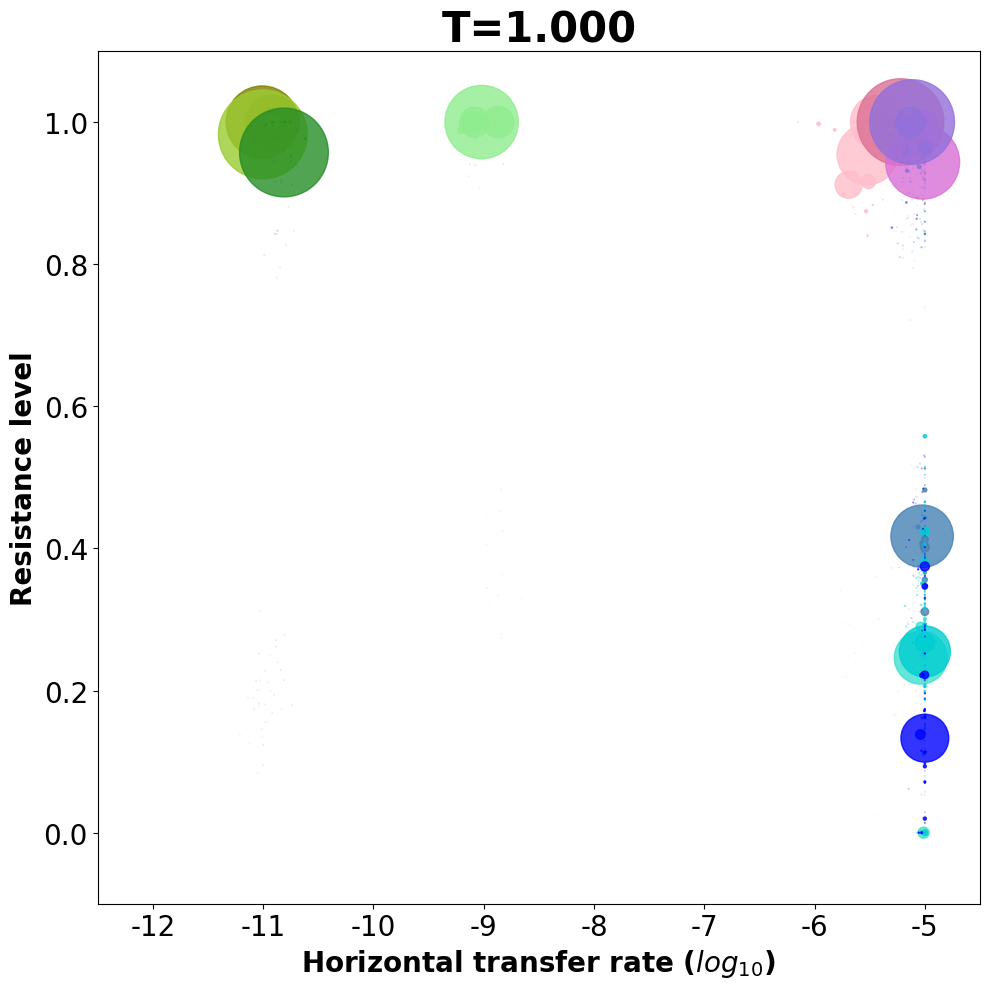

In [23]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
color=LinearSegmentedColormap.from_list("",["olive","yellowgreen","lightgreen","forestgreen","turquoise","steelblue","darkturquoise","blue","pink","palevioletred","orchid","mediumpurple"])
nb_mges_final=np.shape(B)[1]-1

norm=200
run=np.repeat(np.arange(1,nb_community+1),nb_mges_final)
a_tot=np.log10(np.tile(a_res,nb_community))
s_tot=np.tile(s_res[1:],nb_community)
mge_1d=np.reshape(B[:,1:],-1,order='C')

res={'run':run,'a_tot':a_tot,'s_tot':s_tot,'density_final':mge_1d/norm}
res_df = pd.DataFrame(data=res)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)

scatter=axs.scatter(data=res_df, x="a_tot", y="s_tot", s="density_final",c="run",cmap=color,alpha=0.8)
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("T=1.000",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

legend1 = axs.legend(*scatter.legend_elements(num=nb_community),loc="lower left", title="Communities",fontsize=15,title_fontsize=15,bbox_to_anchor=(1.02, 0.15))
axs.add_artist(legend1)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

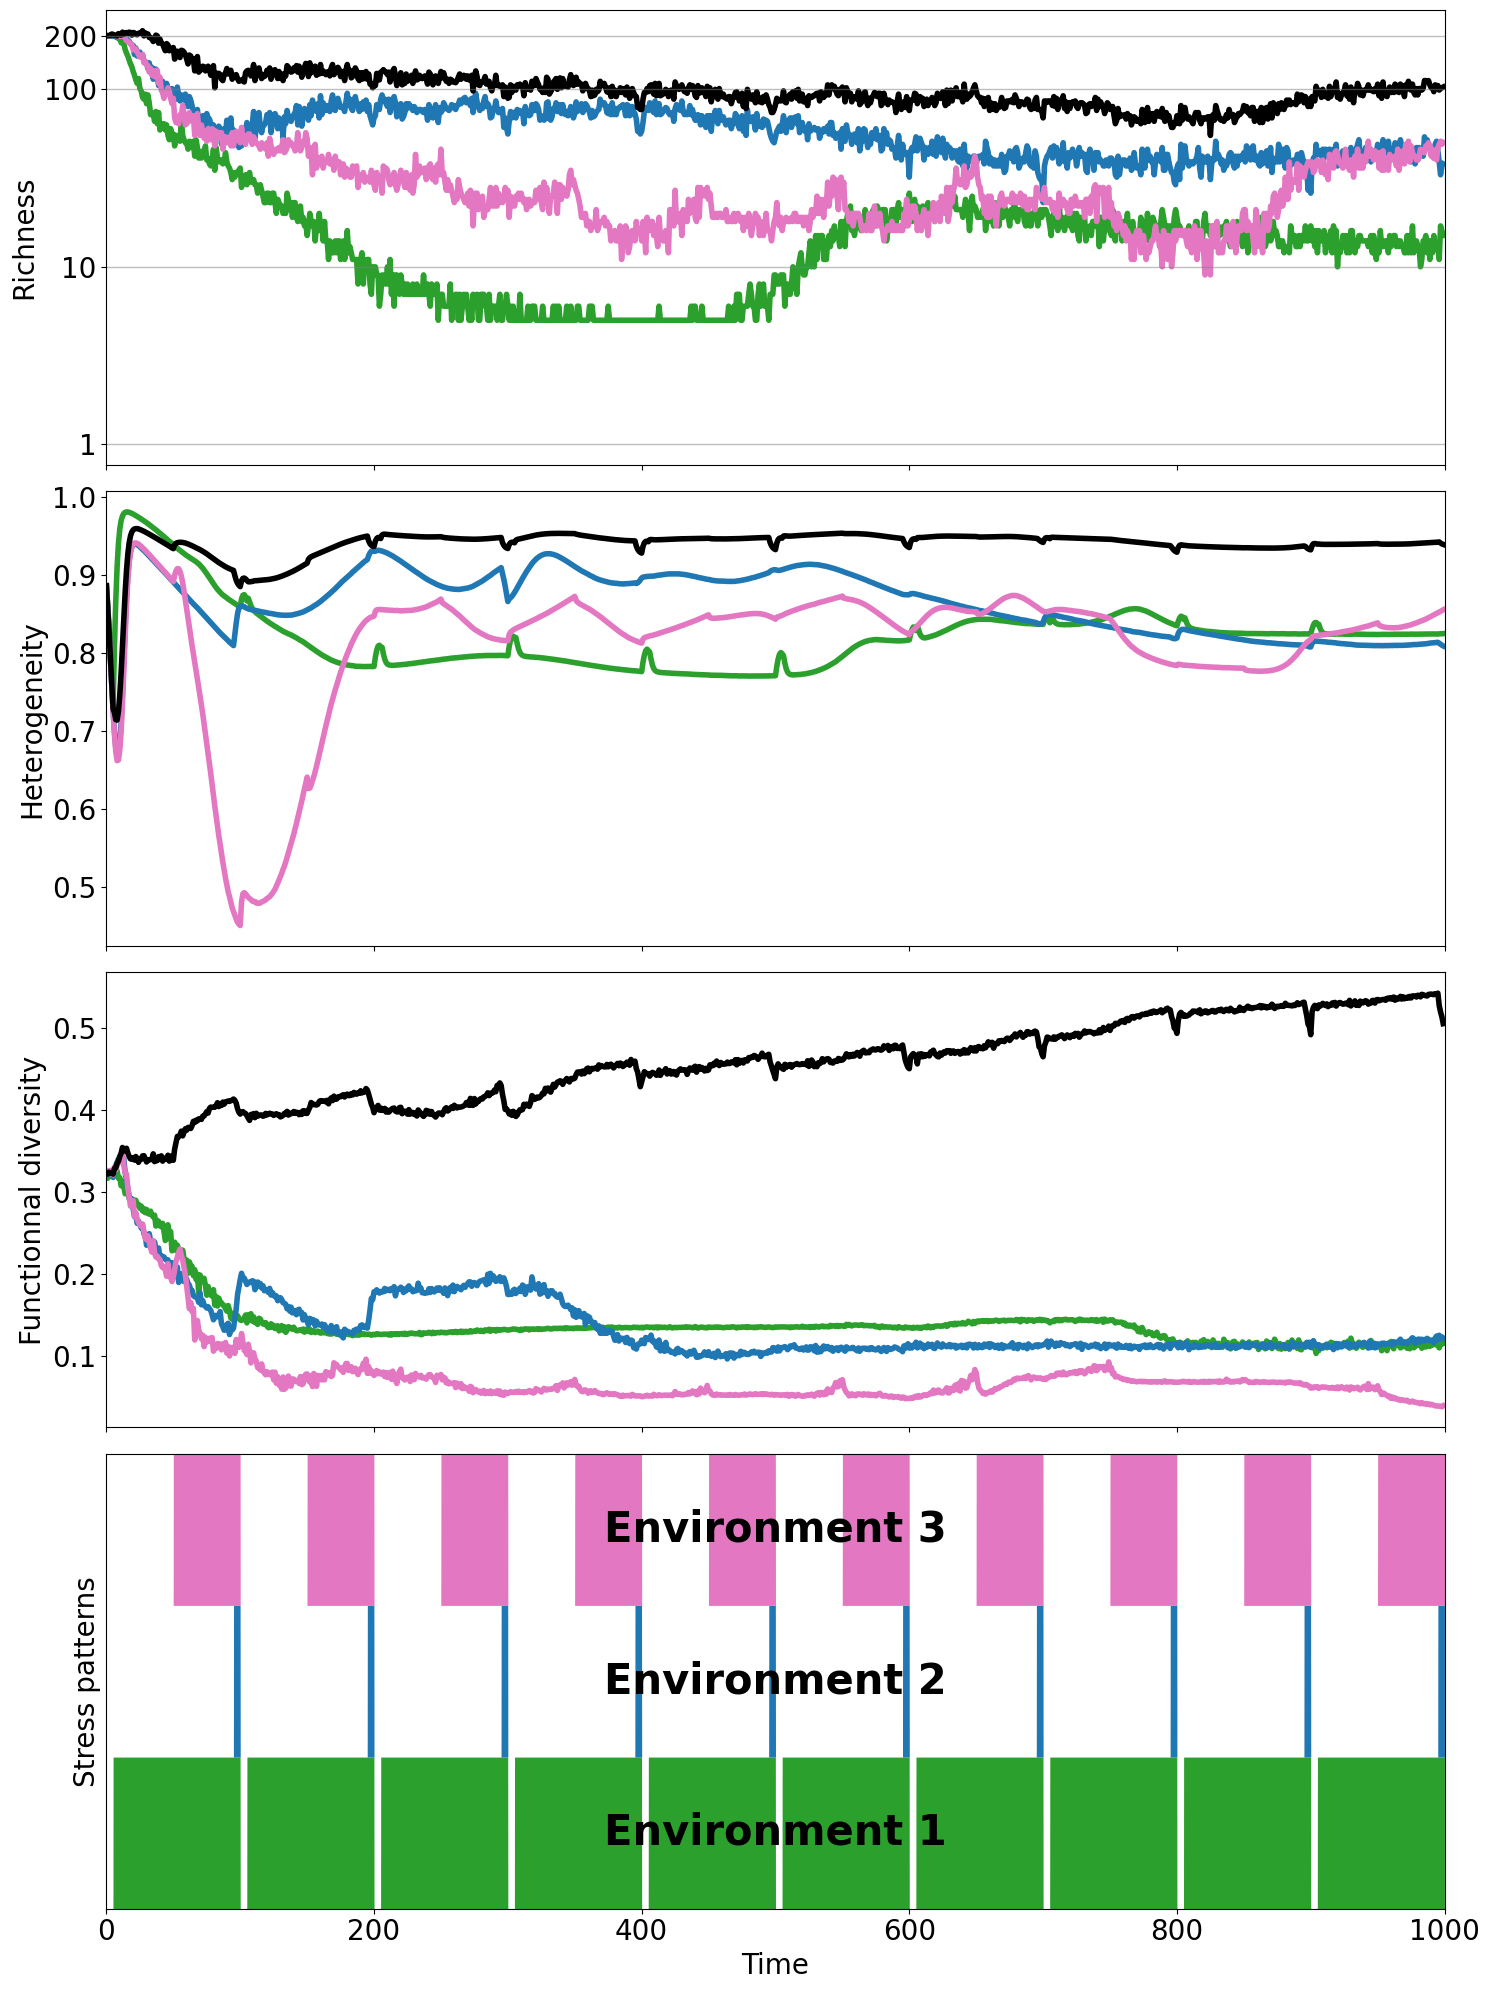

In [24]:
xticks=np.arange(0,T+1,200)
#yticks=np.round(np.arange(0,1.1,0.2),1)
t=np.arange(0,T,dt*10)
fig, axs = plt.subplots(4,1,figsize=(15,20),sharex=True,sharey=False,gridspec_kw={'height_ratios': [1, 1, 1, 1]})

axs[0].plot(t,np.log10(richness_l[:,0]),color="tab:green",linewidth=4)
axs[0].plot(t,np.log10(richness_l[:,1]),color="tab:blue",linewidth=4)
axs[0].plot(t,np.log10(richness_l[:,2]),color="tab:pink",linewidth=4)
axs[0].plot(t,np.log10(richness_g),color="black",linewidth=4)
axs[0].set_ylabel('Richness',size=20)
axs[0].hlines(np.log10([1,10,100,200]),0,T,color="grey",alpha=0.5,linewidth=1)
axs[0].set_yticks(np.log10([1,10,100,200]))
axs[0].set_yticklabels([1,10,100,200],rotation=0,size=20)

axs[1].plot(t,gini_simpson_l[:,0],color="tab:green",linewidth=4)
axs[1].plot(t,gini_simpson_l[:,1],color="tab:blue",linewidth=4)
axs[1].plot(t,gini_simpson_l[:,2],color="tab:pink",linewidth=4)
axs[1].plot(t,gini_simpson_g,color="black",linewidth=4)
axs[1].set_ylabel('Heterogeneity',size=20)
axs[1].tick_params("y",labelsize=20)

axs[2].plot(t,diversity_l[:,0],color="tab:green",linewidth=4)
axs[2].plot(t,diversity_l[:,1],color="tab:blue",linewidth=4)
axs[2].plot(t,diversity_l[:,2],color="tab:pink",linewidth=4)
axs[2].plot(t,diversity_g,color="black",linewidth=4)
axs[2].set_ylabel('Functionnal diversity',size=20)
axs[2].tick_params("y",labelsize=20)

t=np.arange(0,T,dt)
axs[3].fill_between(t,0,S[0,:int(T/dt)],color="tab:green",linewidth=0)
axs[3].fill_between(t,0.9,S[4,:int(T/dt)]+0.9,color="tab:blue",linewidth=0)
axs[3].fill_between(t,1.8,S[8,:int(T/dt)]+1.8,color="tab:pink",linewidth=0)
axs[3].set_xlabel('Time',size=20)
axs[3].set_ylabel('Stress patterns',size=20)
axs[3].tick_params("both",labelsize=20)
axs[3].set_yticks([])
axs[3].set_xlim(0,T)
axs[3].set_ylim(0,0.9*3)
axs[3].text(500,0.45,'Environment 1',ha='center',va='center',size=30,color='black',weight='bold')
axs[3].text(500,0.45+0.9,'Environment 2',ha='center',va='center',size=30,color='black',weight='bold')
axs[3].text(500,0.45+1.8,'Environment 3',ha='center',va='center',size=30,color='black',weight='bold')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## PANEL B

In [27]:
repertory='simulated_data/unified_model_sensibility_analysis/'

In [28]:
innovation_vector=np.array([0,1e-6,1e-5,1.25e-5,2.5e-5,5e-5,1e-4])
dispersion_vector=np.array([0,1e-9,1e-6,1e-5,1e-4,1e-3,1e-2])
nb_innovation=np.size(innovation_vector)
nb_dispersion=np.size(dispersion_vector)
nb_replicats=25

richesse_alpha_mean=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
richesse_gamma=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
richesse_beta=np.zeros((nb_innovation,nb_dispersion,nb_replicats))

for i in range(nb_dispersion):
    for j in range(nb_innovation):
        sub_repertory=repertory+"dispersion="+str(dispersion_vector[i])+"_innovation="+str(innovation_vector[j])+"/"
        for k in range(nb_replicats):
            data = np.loadtxt(sub_repertory+'simulation_'+str(k)+".csv", delimiter=',')
            B=data[:12,1:]
            B_sample=plasmid_sampling(B)
            richesse_gamma[j,i,k]=np.sum(np.sum(B_sample,0)>0)
            richesse_alpha=np.sum(B_sample>0,1)
            richesse_alpha_mean[j,i,k]=np.mean(richesse_alpha)
            richesse_beta[j,i,k]=richesse_gamma[j,i,k]/richesse_alpha_mean[j,i,k]

In [29]:
print(np.max(np.mean(richesse_gamma,2)))
print(np.max(np.mean(richesse_beta,2)))
print(np.max(np.mean(richesse_alpha_mean,2)))

v_min=0
v_max=np.max(np.mean(richesse_gamma,2))

121.96
12.0
30.290000000000006


/tmp/ipykernel_22084/449482430.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


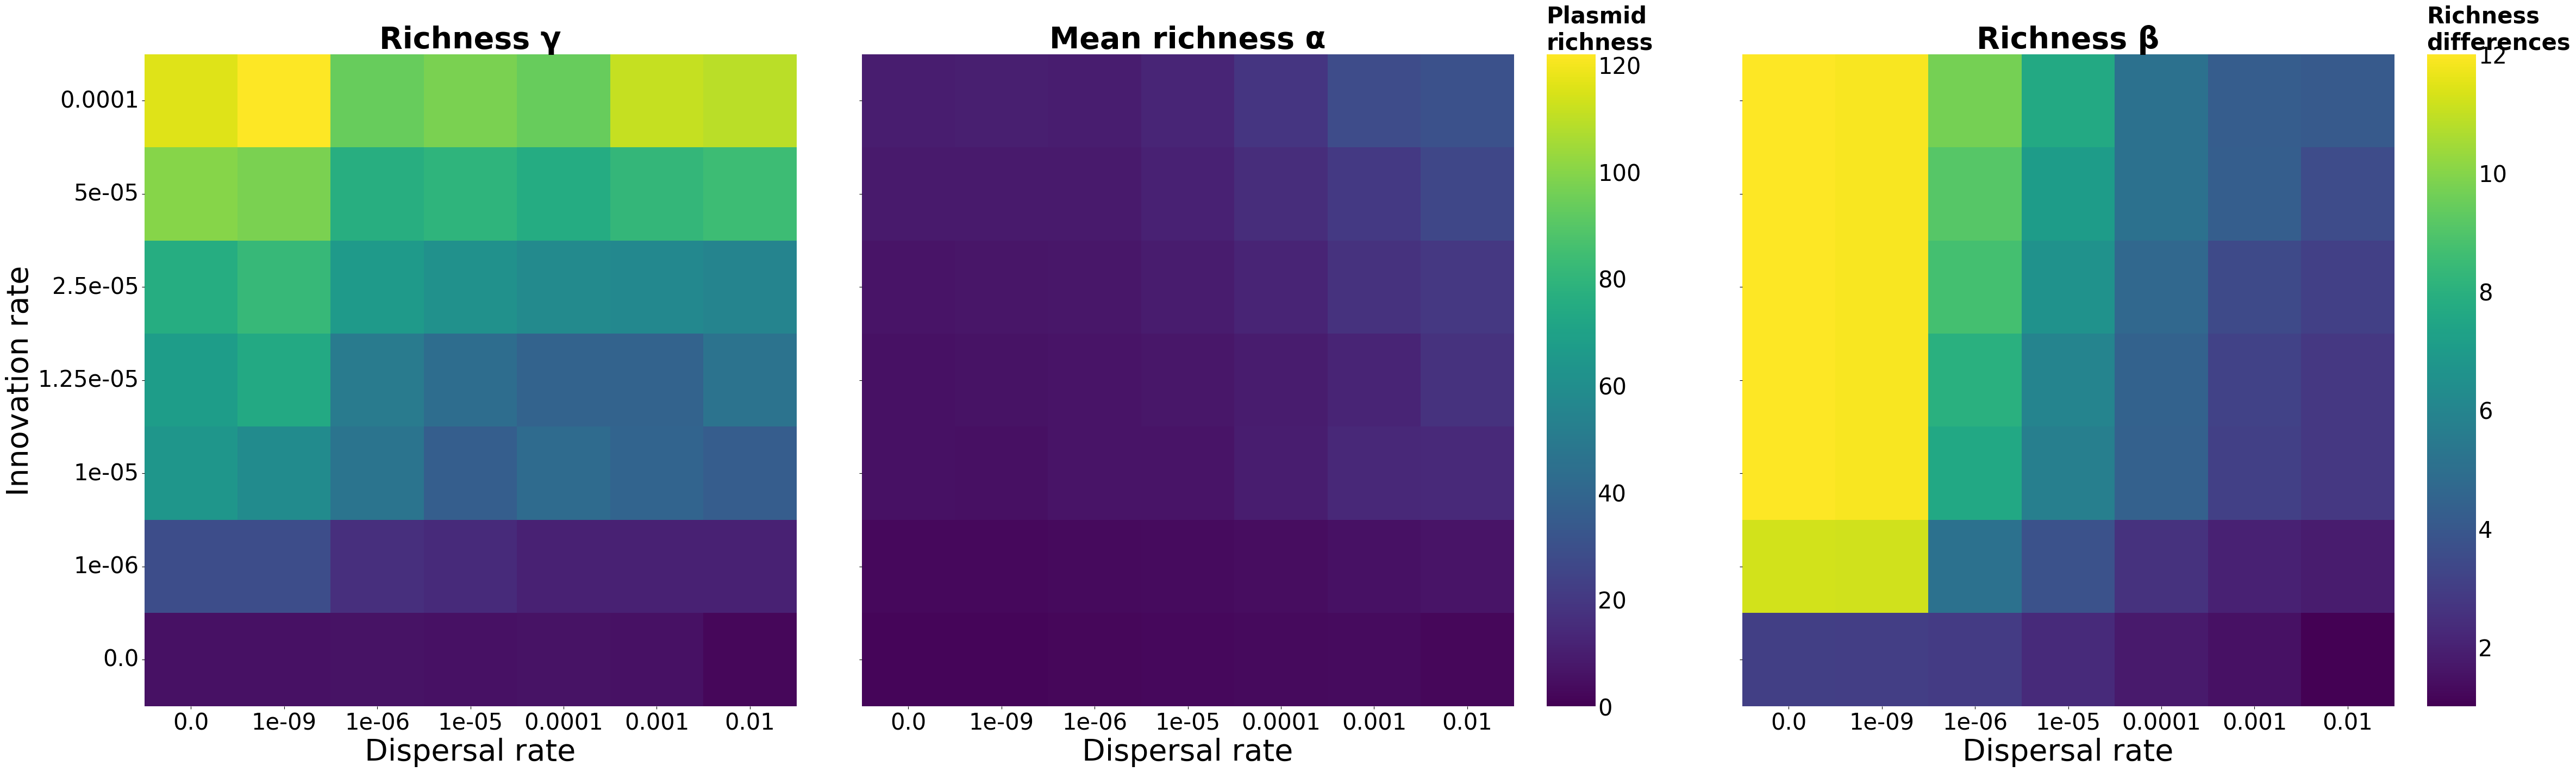

In [31]:
fig = plt.figure(figsize=(60, 15))
gs = GridSpec(nrows=1, ncols=5, width_ratios=[1, 1, 0.1, 1, 0.1], wspace=0.25)

# Positions [left, bottom, width, height]
ax_gamma     = fig.add_axes([0.05, 0.1, 0.2, 0.8])   # Heatmap γ
ax_alpha     = fig.add_axes([0.27, 0.1, 0.2, 0.8])   # Heatmap α
cbar_ax1     = fig.add_axes([0.48, 0.1, 0.015, 0.8]) # Colorbar γ
ax_beta      = fig.add_axes([0.54, 0.1, 0.2, 0.8])   # Heatmap β
cbar_ax2     = fig.add_axes([0.75, 0.1, 0.015, 0.8]) # Colorbar β

# --- Heatmap γ ---
sns.heatmap(np.mean(richesse_gamma, 2), ax=ax_gamma,
            cbar=True, cbar_ax=cbar_ax1, cmap="viridis",
            vmin=v_min, vmax=v_max)
ax_gamma.set_xlabel('Dispersal rate', size=40)
ax_gamma.set_ylabel('Innovation rate', size=40)
ax_gamma.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_gamma.set_yticklabels(innovation_vector, rotation=0, size=30)
ax_gamma.set_title('Richness γ', size=40, weight='bold')
ax_gamma.invert_yaxis()
cbar_ax1.tick_params(labelsize=30, length=0)
cbar_ax1.set_title('Plasmid\nrichness', size=30, weight="bold", loc="left")

# --- Heatmap α ---
sns.heatmap(np.mean(richesse_alpha_mean, 2), ax=ax_alpha,
            cbar=False, cmap="viridis",
            vmin=v_min, vmax=v_max)
ax_alpha.set_xlabel('Dispersal rate', size=40)
ax_alpha.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_alpha.set_yticklabels([])
ax_alpha.set_title('Mean richness α', size=40, weight='bold')
ax_alpha.invert_yaxis()

# --- Heatmap β ---
sns.heatmap(np.mean(richesse_beta, 2), ax=ax_beta,
            cbar=True, cbar_ax=cbar_ax2, cmap="viridis",
            vmin=1, vmax=np.max(np.mean(richesse_beta, 2)))
ax_beta.set_xlabel('Dispersal rate', size=40)
ax_beta.set_ylabel('')
ax_beta.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_beta.set_yticklabels([])
ax_beta.set_title('Richness β', size=40, weight='bold')
ax_beta.invert_yaxis()
cbar_ax2.tick_params(labelsize=30, length=0)
cbar_ax2.set_title('Richness\ndifferences', size=30, weight="bold", loc="left")

fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## PANEL C

In [32]:
def gini_simpson_global(B):
    tmp=B[:,1:]/np.sum(B[:,1:])
    return(1-np.sum(tmp**2))

In [33]:
def gini_simpson_local(B):
    tmp=B[:,1:]/np.reshape(np.sum(B[:,1:],1),(12,-1))
    sa=1-np.sum(tmp**2,1)
    return(np.mean(sa))

In [34]:
innovation_vector=np.array([0,1e-6,1e-5,1.25e-5,2.5e-5,5e-5,1e-4])
dispersion_vector=np.array([0,1e-9,1e-6,1e-5,1e-4,1e-3,1e-2])
nb_innovation=np.size(innovation_vector)
nb_dispersion=np.size(dispersion_vector)
nb_replicats=25

gini_simpson_alpha_mean=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
gini_simpson_gamma=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
gini_simpson_beta=np.zeros((nb_innovation,nb_dispersion,nb_replicats))

for i in range(nb_dispersion):
    for j in range(nb_innovation):
        sub_repertory=repertory+"dispersion="+str(dispersion_vector[i])+"_innovation="+str(innovation_vector[j])+"/"
        for k in range(nb_replicats):
            data = np.loadtxt(sub_repertory+'simulation_'+str(k)+".csv", delimiter=',')
            B=data[:12]
            gini_simpson_gamma[j,i,k]=gini_simpson_global(B)
            gini_simpson_alpha_mean[j,i,k]=gini_simpson_local(B)
            gini_simpson_beta[j,i,k]=gini_simpson_gamma[j,i,k]/gini_simpson_alpha_mean[j,i,k]

In [35]:
print(np.min(np.mean(gini_simpson_gamma,2)))
print(np.min(np.mean(gini_simpson_beta,2)))
print(np.min(np.mean(gini_simpson_alpha_mean,2)))

v_max=1
v_min=0#np.min(np.mean(gini_simpson_alpha_mean,2))

0.9174377115624207
1.9858767751658248
0.021775017380323662


/tmp/ipykernel_22084/3625478395.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


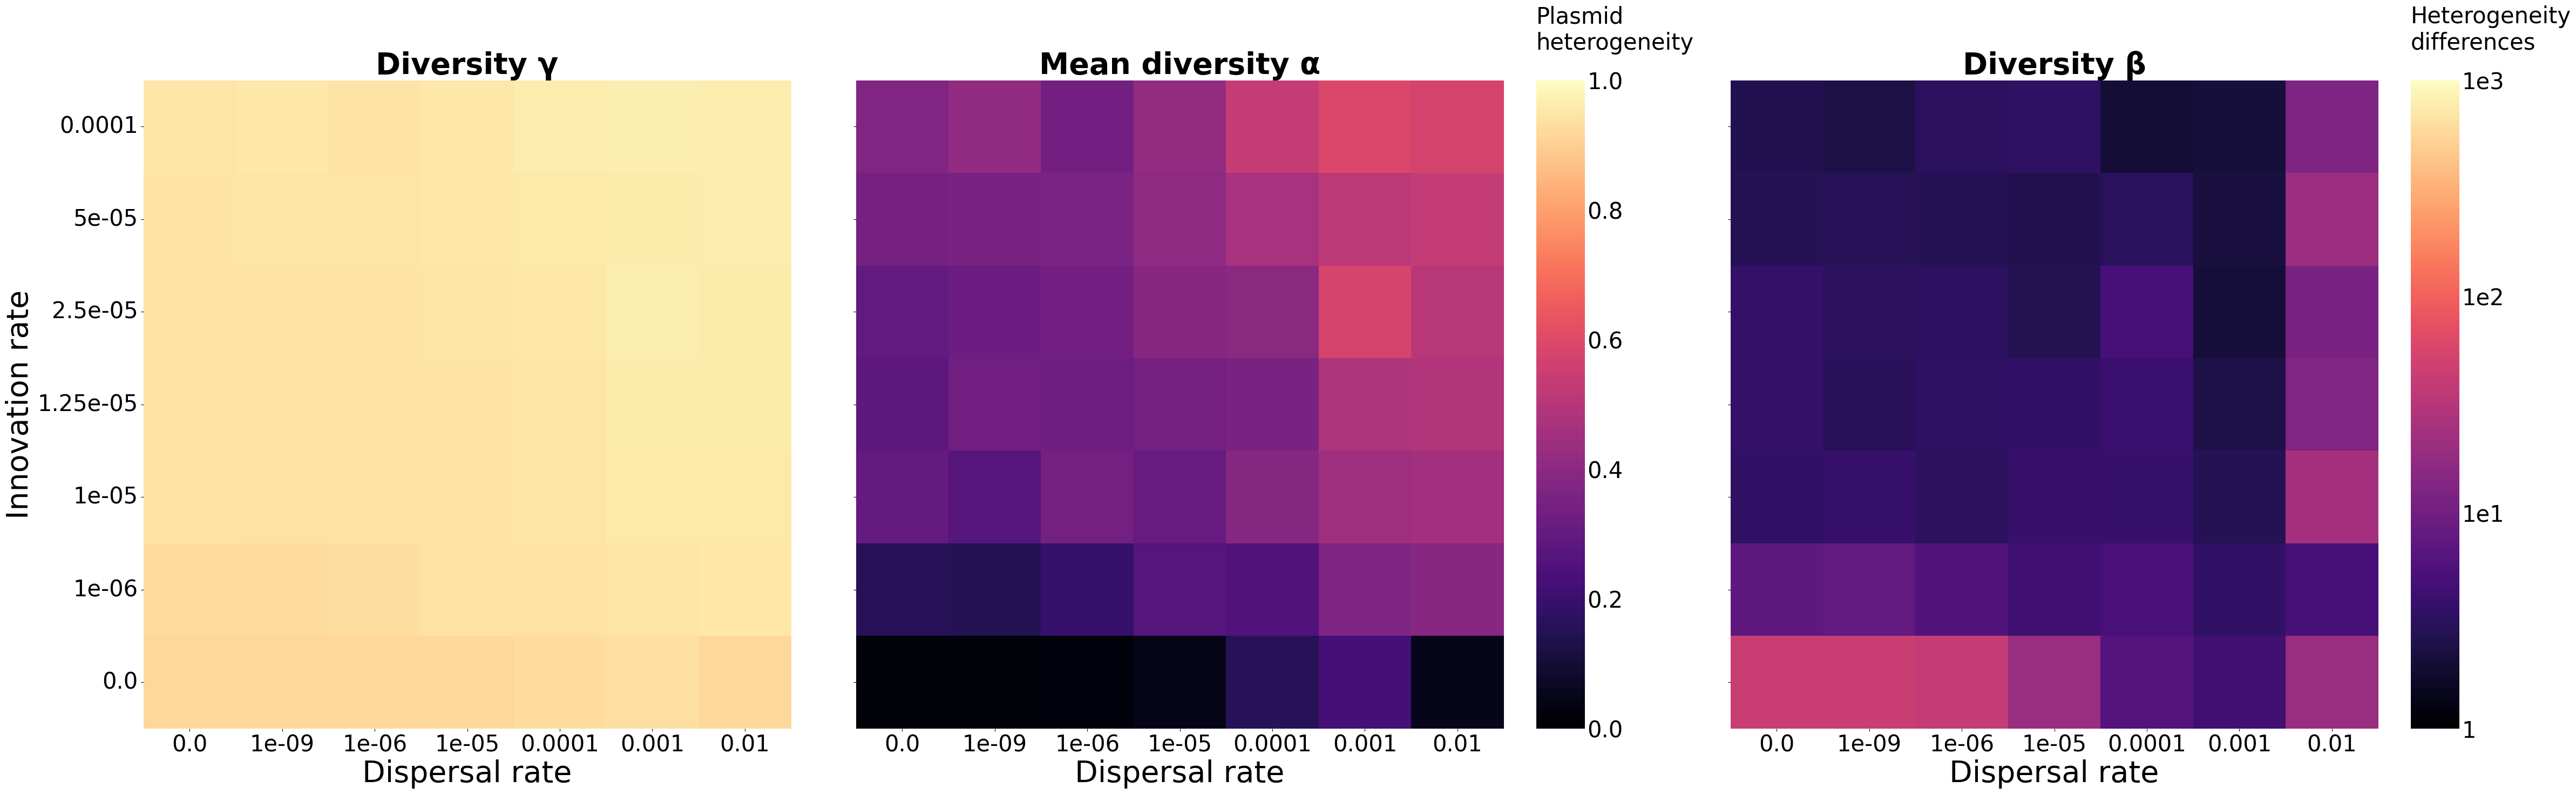

In [36]:
fig = plt.figure(figsize=(60, 15))
gs = GridSpec(nrows=1, ncols=5, width_ratios=[1, 1, 0.1, 1, 0.1], wspace=0.25)

# Positions [left, bottom, width, height]
ax_gamma     = fig.add_axes([0.05, 0.1, 0.2, 0.8])   # Heatmap γ
ax_alpha     = fig.add_axes([0.27, 0.1, 0.2, 0.8])   # Heatmap α
cbar_ax1     = fig.add_axes([0.48, 0.1, 0.015, 0.8]) # Colorbar γ
ax_beta      = fig.add_axes([0.54, 0.1, 0.2, 0.8])   # Heatmap β
cbar_ax2     = fig.add_axes([0.75, 0.1, 0.015, 0.8]) # Colorbar β

# --- Heatmap γ ---
sns.heatmap(np.mean(gini_simpson_gamma, 2), ax=ax_gamma,
            cbar=True, cbar_ax=cbar_ax1, cmap="magma",
            vmin=v_min, vmax=v_max)
ax_gamma.set_xlabel('Dispersal rate', size=40)
ax_gamma.set_ylabel('Innovation rate', size=40)
ax_gamma.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_gamma.set_yticklabels(innovation_vector, rotation=0, size=30)
ax_gamma.set_title('Diversity γ', size=40, weight='bold')
ax_gamma.invert_yaxis()
cbar_ax1.tick_params(labelsize=30, length=0)
cbar_ax1.set_title('Plasmid\nheterogeneity\n', size=30, loc="left")

# --- Heatmap α ---
sns.heatmap(np.mean(gini_simpson_alpha_mean, 2), ax=ax_alpha,
            cbar=False, cmap="magma",
            vmin=v_min, vmax=v_max)
ax_alpha.set_xlabel('Dispersal rate', size=40)
ax_alpha.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_alpha.set_yticklabels([])
ax_alpha.set_title('Mean diversity α', size=40, weight='bold')
ax_alpha.invert_yaxis()

# --- Heatmap β ---
sns.heatmap(np.log10(np.mean(gini_simpson_beta, 2)), ax=ax_beta,
            cbar=True, cbar_ax=cbar_ax2, cmap="magma",
            vmin=0, vmax=3)#np.max(np.mean(gini_simpson_beta, 2)))
ax_beta.set_xlabel('Dispersal rate', size=40)
ax_beta.set_ylabel('')
ax_beta.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_beta.set_yticklabels([])
ax_beta.set_title('Diversity β', size=40, weight='bold')
ax_beta.invert_yaxis()

cbar_ax2.tick_params(labelsize=30, length=0)
cbar_ax2.set_yticks([0,1,2,3])
cbar_ax2.set_yticklabels([1,'1e1','1e2','1e3'])
cbar_ax2.set_title('Heterogeneity\ndifferences\n', size=30, loc="left")

fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## PANEL D

In [37]:
def rao_local(B,distance_matrix):
    n=np.shape(B)[0]
    res=np.zeros(n)
    for i in range(n):
        B_freq=B[i]/np.sum(B[i])
        res[i]=np.sum(B_freq*np.reshape(B_freq,(-1,1))*distance_matrix)
    return res

In [38]:
def rao_global(B,distance_matrix):
    B_freq=B/np.sum(B)
    B_freq=np.sum(B_freq,0)
    res=np.sum(B_freq*np.reshape(B_freq,(-1,1))*distance_matrix)
    return res

In [39]:
innovation_vector=np.array([0,1e-6,1e-5,1.25e-5,2.5e-5,5e-5,1e-4])
dispersion_vector=np.array([0,1e-9,1e-6,1e-5,1e-4,1e-3,1e-2])
nb_innovation=np.size(innovation_vector)
nb_dispersion=np.size(dispersion_vector)
nb_replicats=25

rao_alpha_mean=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
rao_gamma=np.zeros((nb_innovation,nb_dispersion,nb_replicats))
rao_beta=np.zeros((nb_innovation,nb_dispersion,nb_replicats))

for i in range(nb_dispersion):
    for j in range(nb_innovation):
        sub_repertory=repertory+"dispersion="+str(dispersion_vector[i])+"_innovation="+str(innovation_vector[j])+"/"
        for k in range(nb_replicats):
            data = np.loadtxt(sub_repertory+'simulation_'+str(k)+".csv", delimiter=',')
            B=data[:12]
            a=data[12,1:]
            s=data[13,1:]
            B_sample=plasmid_sampling(B)
            a_transfo=alpha_0_1(a)
            d_matrix=distance(a_transfo,s)
            rao_gamma[j,i,k]=rao_global(B_sample,d_matrix)
            rao_alpha=rao_local(B_sample,d_matrix)
            rao_alpha_mean[j,i,k]=np.mean(rao_alpha)
            rao_beta[j,i,k]=rao_gamma[j,i,k]/rao_alpha_mean[j,i,k]

In [40]:
print(np.max(np.mean(rao_gamma,2)))
print(np.max(np.nanmean(rao_beta,2)))
print(np.max(np.mean(rao_alpha_mean,2)))

v_min=0
v_max=np.max(np.mean(rao_gamma,2))

0.5399277595066261
489.8522714499887
0.1295892323959483


/tmp/ipykernel_22084/3103888668.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


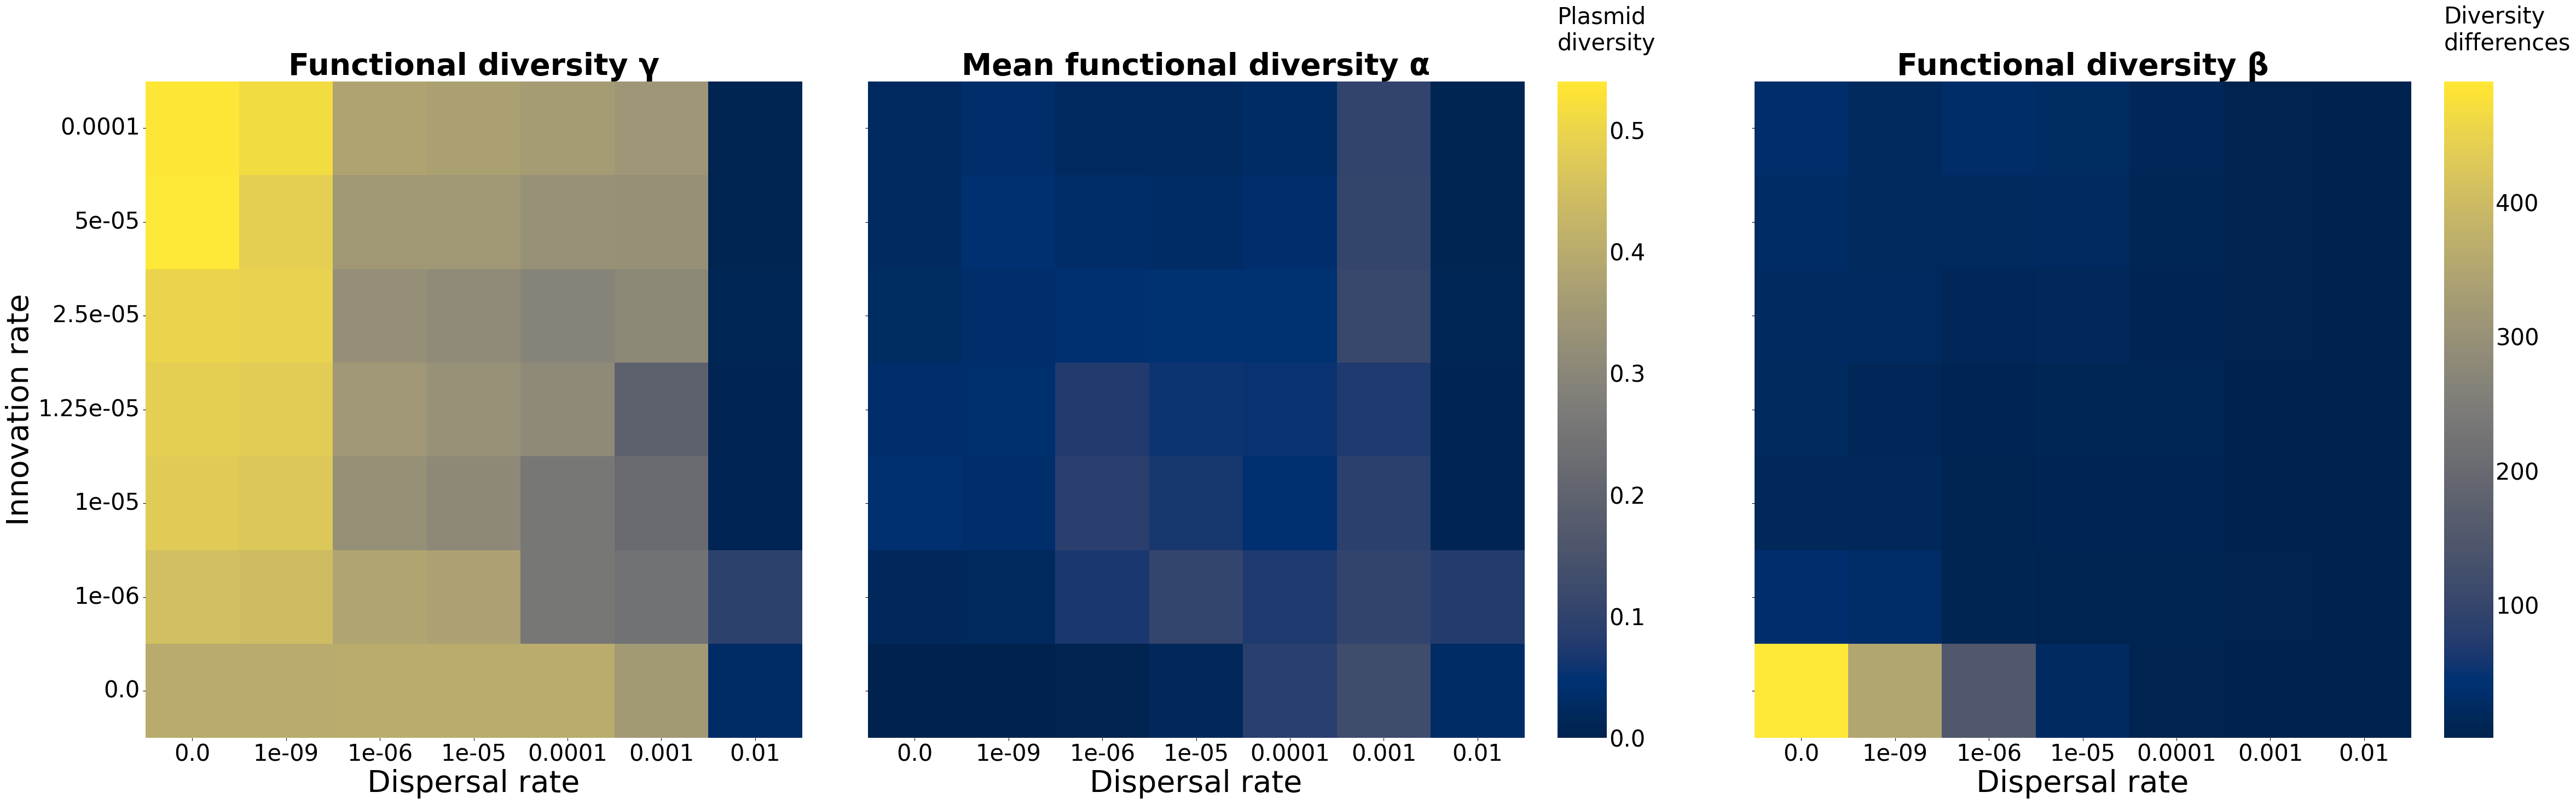

In [41]:
fig = plt.figure(figsize=(60, 15))
gs = GridSpec(nrows=1, ncols=5, width_ratios=[1, 1, 0.1, 1, 0.1], wspace=0.25)

# Positions [left, bottom, width, height]
ax_gamma     = fig.add_axes([0.05, 0.1, 0.2, 0.8])   # Heatmap γ
ax_alpha     = fig.add_axes([0.27, 0.1, 0.2, 0.8])   # Heatmap α
cbar_ax1     = fig.add_axes([0.48, 0.1, 0.015, 0.8]) # Colorbar γ
ax_beta      = fig.add_axes([0.54, 0.1, 0.2, 0.8])   # Heatmap β
cbar_ax2     = fig.add_axes([0.75, 0.1, 0.015, 0.8]) # Colorbar β

# --- Heatmap γ ---
sns.heatmap(np.mean(rao_gamma, 2), ax=ax_gamma,
            cbar=True, cbar_ax=cbar_ax1, cmap="cividis",
            vmin=v_min, vmax=v_max)
ax_gamma.set_xlabel('Dispersal rate', size=40)
ax_gamma.set_ylabel('Innovation rate', size=40)
ax_gamma.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_gamma.set_yticklabels(innovation_vector, rotation=0, size=30)
ax_gamma.set_title('Functional diversity γ', size=40, weight='bold')
ax_gamma.invert_yaxis()
cbar_ax1.tick_params(labelsize=30, length=0)
cbar_ax1.set_title('Plasmid\ndiversity\n', size=30, loc="left")

# --- Heatmap α ---
sns.heatmap(np.mean(rao_alpha_mean, 2), ax=ax_alpha,
            cbar=False, cmap="cividis",
            vmin=v_min, vmax=v_max)
ax_alpha.set_xlabel('Dispersal rate', size=40)
ax_alpha.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_alpha.set_yticklabels([])
ax_alpha.set_title('Mean functional diversity α', size=40, weight='bold')
ax_alpha.invert_yaxis()

# --- Heatmap β ---
sns.heatmap(np.nanmean(rao_beta, 2), ax=ax_beta,
            cbar=True, cbar_ax=cbar_ax2, cmap="cividis",
            vmin=1, vmax=np.max(np.nanmean(rao_beta, 2)))
ax_beta.set_xlabel('Dispersal rate', size=40)
ax_beta.set_ylabel('')
ax_beta.set_xticklabels(dispersion_vector, rotation=0, size=30)
ax_beta.set_yticklabels([])
ax_beta.set_title('Functional diversity β', size=40, weight='bold')
ax_beta.invert_yaxis()
cbar_ax2.tick_params(labelsize=30, length=0)
cbar_ax2.set_title('Diversity\ndifferences\n', size=30, loc="left")

fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()